In [1]:
from setup import dask_init, dask_shutdown
import dask.distributed as dd
import dask.dataframe as ddf
from tqdm import tqdm

import pandas as pd
import numpy as np

import ingestion as ing
import processing as prc

import datetime as dt

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

%load_ext autoreload
%autoreload 2

In [2]:
# PANDAS SETUP
pd.options.mode.use_inf_as_na = True

# DASK SETUP
client, cluster = dask_init()
cluster

In [9]:
scores_ddf = ing.read_parquet('RefinedData\BeerAdvocate\\users_with_scores.parquet')
scores_ddf = scores_ddf.compute()
scores_ddf.head()

,n_ratings,n_reviews,uid,username,joined,location,country,cfm_score,exp_score,xpl_score,adv_score,is_cfm,is_exp,is_xpl,is_adv
0,7820,465,nmann08.184925,nmann08,2008-01-07 11:00:00,"United States, Washington",United States,-0.875556,-0.423436,0.276726,0.066368,0,0,1,0
1,2521,2504,stjamesgate.163714,StJamesGate,2007-10-08 10:00:00,"United States, New York",United States,-0.516299,-0.282777,0.473622,0.037287,0,0,1,0
2,2326,0,hellpop65.48993,Hellpop65,2005-11-14 11:00:00,"United States, Kansas",United States,-1.783445,-0.621249,0.11264,0.11307,0,0,0,0
3,3098,0,latarnik.52897,Latarnik,2005-12-02 11:00:00,"United States, New Jersey",United States,-0.451196,-0.362152,0.171724,0.244028,0,0,0,1
4,1866,23,rochefortchris.697017,RochefortChris,2012-10-02 10:00:00,"United States, North Carolina",United States,-1.375863,-0.414637,0.209539,0.084137,0,0,1,0


In [8]:
ratings_ddf = ing.read_parquet('RefinedData\BeerAdvocate\\ratings.parquet')
ratings_ddf = ratings_ddf.compute()
ratings_ddf.head()

,date,bid,uid,rating,has_review,review,compound
0,2015-08-20 10:00:00,142544,nmann08.184925,2.88,True,"From a bottle, pours a piss yellow color with ...",0
1,2015-11-14 11:00:00,120824,nmann08.184925,3.56,False,None,0
2,2011-11-18 11:00:00,47581,nmann08.184925,4.50,False,None,0
3,2013-05-03 10:00:00,93113,nmann08.184925,3.75,False,None,0
4,2015-01-24 11:00:00,875,nmann08.184925,3.81,False,None,0


In [13]:
beers_ddf = ing.read_parquet('RefinedData\BeerAdvocate\\beers.parquet')
beers_ddf = beers_ddf.compute()
beers_ddf.head()

,bid,n_ratings,avg_rating,n_reviews,review_rate,ba_score,bros_score,name,style,abv
0,5,1538,3.441203,520,0.338101,78.0,89.0,Amber,Vienna Lager,4.5
1,6,2660,3.657617,968,0.363910,82.0,90.0,Turbodog,English Brown Ale,5.6
2,7,2977,3.265694,778,0.261337,74.0,88.0,Purple Haze,Fruit / Vegetable Beer,4.2
3,8,132,3.290682,70,0.530303,77.0,89.0,Wheat,American Adjunct Lager,4.2
4,9,215,3.172698,120,0.558140,74.0,83.0,Golden,American Pale Lager,4.2


# Goal of the analysis:
1) what types of beers are rated more by each categories relative to their number of ratings
2) what type of beer each category like more (ie. are the ratings better for some category of beers)

## What style of beer are more rated by each category

In [17]:
# get user for each category
cfm_users = scores_ddf[scores_ddf["is_cfm"] == True]
exp_users = scores_ddf[scores_ddf["is_exp"] == True]
xpl_users = scores_ddf[scores_ddf["is_xpl"] == True]
adv_users = scores_ddf[scores_ddf["is_adv"] == True]

# group by rating for each category
cfm_ratings = ratings_ddf[ratings_ddf["uid"].isin(cfm_users["uid"])]
exp_ratings = ratings_ddf[ratings_ddf["uid"].isin(exp_users["uid"])]
xpl_ratings = ratings_ddf[ratings_ddf["uid"].isin(xpl_users["uid"])]
adv_ratings = ratings_ddf[ratings_ddf["uid"].isin(adv_users["uid"])]



In [36]:
cfm_ratings

,date,bid,uid,rating,has_review,review,compound
1862,2014-01-25 11:00:00,19827,jaydoc.265507,3.25,False,None,0
1863,2014-01-25 11:00:00,20842,jaydoc.265507,3.75,False,None,0
1864,2013-11-27 11:00:00,4720,jaydoc.265507,3.50,False,None,0
1865,2013-11-27 11:00:00,41037,jaydoc.265507,4.00,False,None,0
1866,2013-11-27 11:00:00,41012,jaydoc.265507,4.00,False,None,0
...,...,...,...,...,...,...,...
154230,2005-11-15 11:00:00,1505,tboom29.8226,3.59,True,This beer pours a very dark auburn red. The no...,0
154284,2005-11-17 11:00:00,25684,skittlebrau.41838,4.43,True,"Wow, where do I start with this one. Well, as ...",0
154328,2013-10-25 10:00:00,70471,hipboy221.727431,3.75,False,None,0
154334,2015-01-29 11:00:00,141790,johlac66.829174,4.38,False,None,0


In [112]:
# get style of beer for each bid
cfm_ratings = cfm_ratings.merge(beers_ddf[["bid", "style"]], on="bid")
exp_ratings = exp_ratings.merge(beers_ddf[["bid", "style"]], on="bid")
xpl_ratings = xpl_ratings.merge(beers_ddf[["bid", "style"]], on="bid")
adv_ratings = adv_ratings.merge(beers_ddf[["bid", "style"]], on="bid")

In [39]:
cfm_ratings.shape

(1271046, 8)

In [47]:
# count of each style for each category
cfm_style_count = cfm_ratings.groupby("style").count()["uid"]
exp_style_count = exp_ratings.groupby("style").count()["uid"]
xpl_style_count = xpl_ratings.groupby("style").count()["uid"]
adv_style_count = adv_ratings.groupby("style").count()["uid"]


In [49]:
# normalize count of each style for each category by number of ratings for each category
cfm_style_count = cfm_style_count / cfm_ratings.shape[0]
exp_style_count = exp_style_count / exp_ratings.shape[0]
xpl_style_count = xpl_style_count / xpl_ratings.shape[0]
adv_style_count = adv_style_count / adv_ratings.shape[0]

In [52]:
# sort by highest count
cfm_style_count = cfm_style_count.sort_values(ascending=False)
exp_style_count = exp_style_count.sort_values(ascending=False)
xpl_style_count = xpl_style_count.sort_values(ascending=False)
adv_style_count = adv_style_count.sort_values(ascending=False)

In [54]:
# get top 10 styles for each category
cfm_style_count = cfm_style_count[:10]
exp_style_count = exp_style_count[:10]
xpl_style_count = xpl_style_count[:10]
adv_style_count = adv_style_count[:10]

Goal: obtain the percentage of rating for each style of beer(percent in terms of their total number of rating) for each category of users

In [28]:
cfm_styles

American IPA                        0.010845
American Pale Ale (APA)             0.005314
American Double / Imperial IPA      0.005147
Saison / Farmhouse Ale              0.004995
American Wild Ale                   0.003772
American Porter                     0.003158
American Double / Imperial Stout    0.003091
American Amber / Red Ale            0.002592
American Stout                      0.002288
American Brown Ale                  0.001748
Name: style, dtype: float64

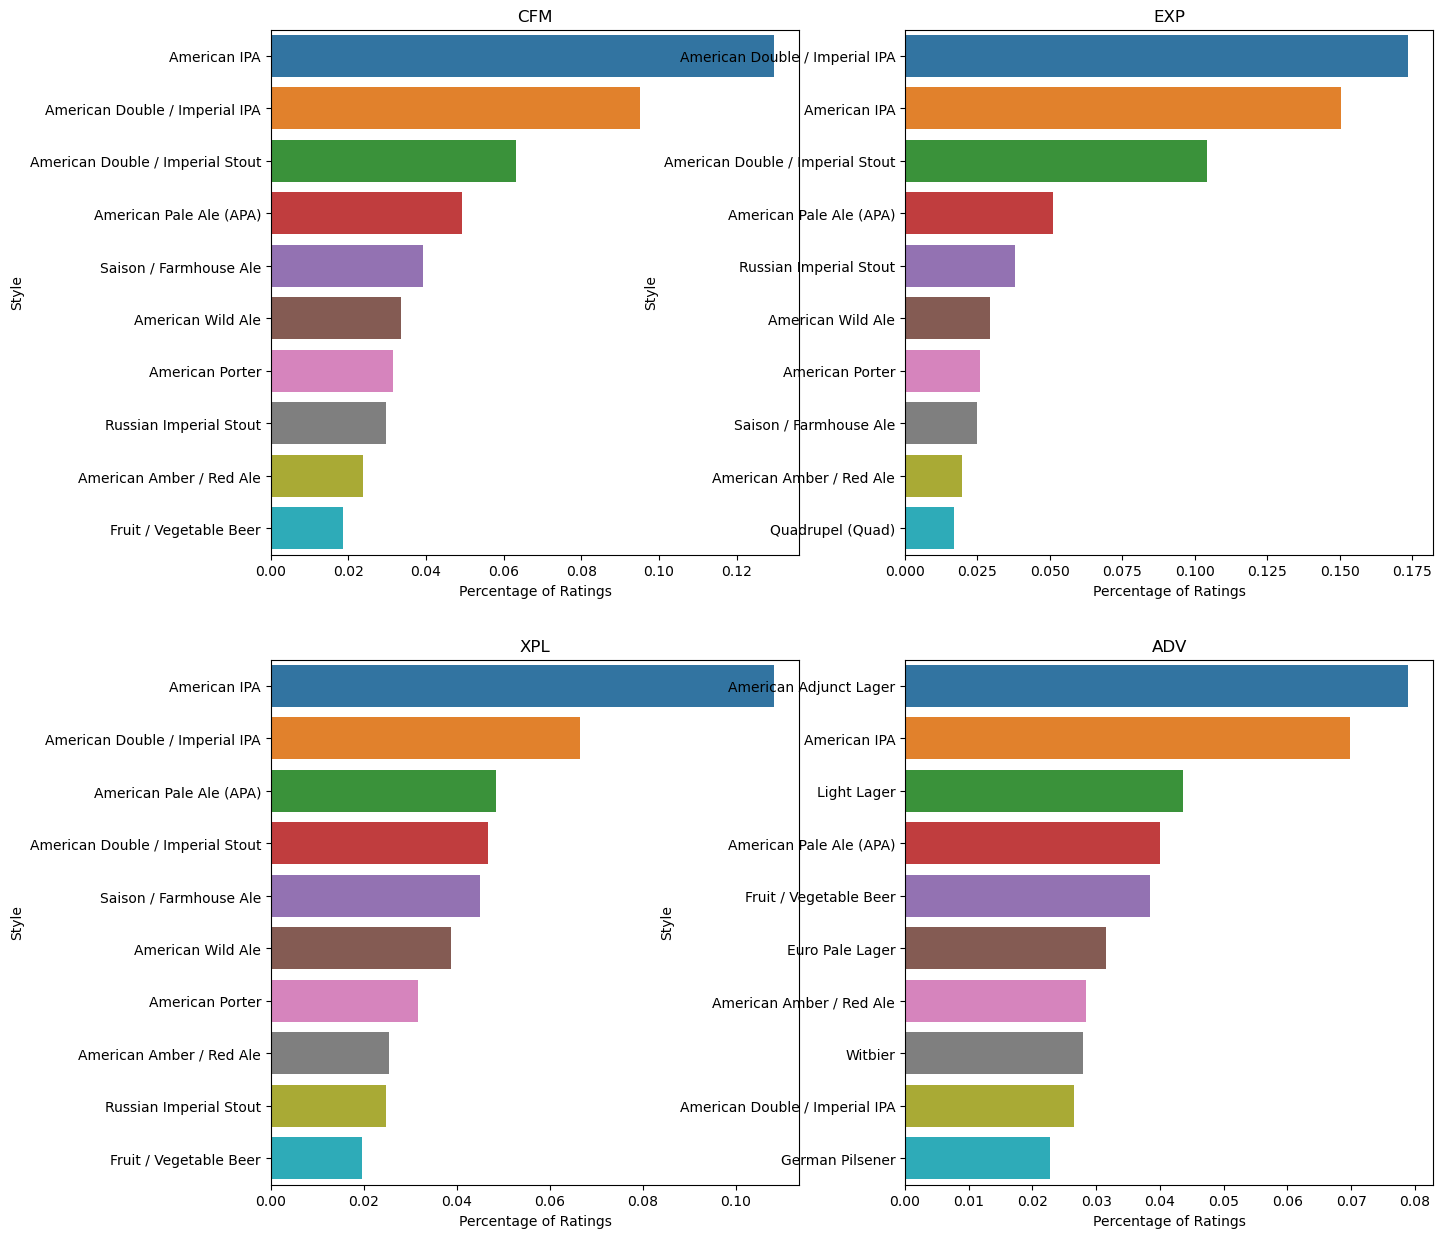

In [62]:
# plot top 10 styles for each category using style_count using seaborn on 4 subplots
fig, axs = plt.subplots(2, 2, figsize=(15, 15))
sns.barplot(x=cfm_style_count.values, y=cfm_style_count.index, ax=axs[0, 0])
sns.barplot(x=exp_style_count.values, y=exp_style_count.index, ax=axs[0, 1])
sns.barplot(x=xpl_style_count.values, y=xpl_style_count.index, ax=axs[1, 0])
sns.barplot(x=adv_style_count.values, y=adv_style_count.index, ax=axs[1, 1])

axs[0, 0].set_title("CFM")
axs[0, 1].set_title("EXP")
axs[1, 0].set_title("XPL")
axs[1, 1].set_title("ADV")

axs[0, 0].set_xlabel("Percentage of Ratings")
axs[0, 1].set_xlabel("Percentage of Ratings")
axs[1, 0].set_xlabel("Percentage of Ratings")
axs[1, 1].set_xlabel("Percentage of Ratings")

axs[0, 0].set_ylabel("Style")
axs[0, 1].set_ylabel("Style")
axs[1, 0].set_ylabel("Style")
axs[1, 1].set_ylabel("Style")

plt.show()







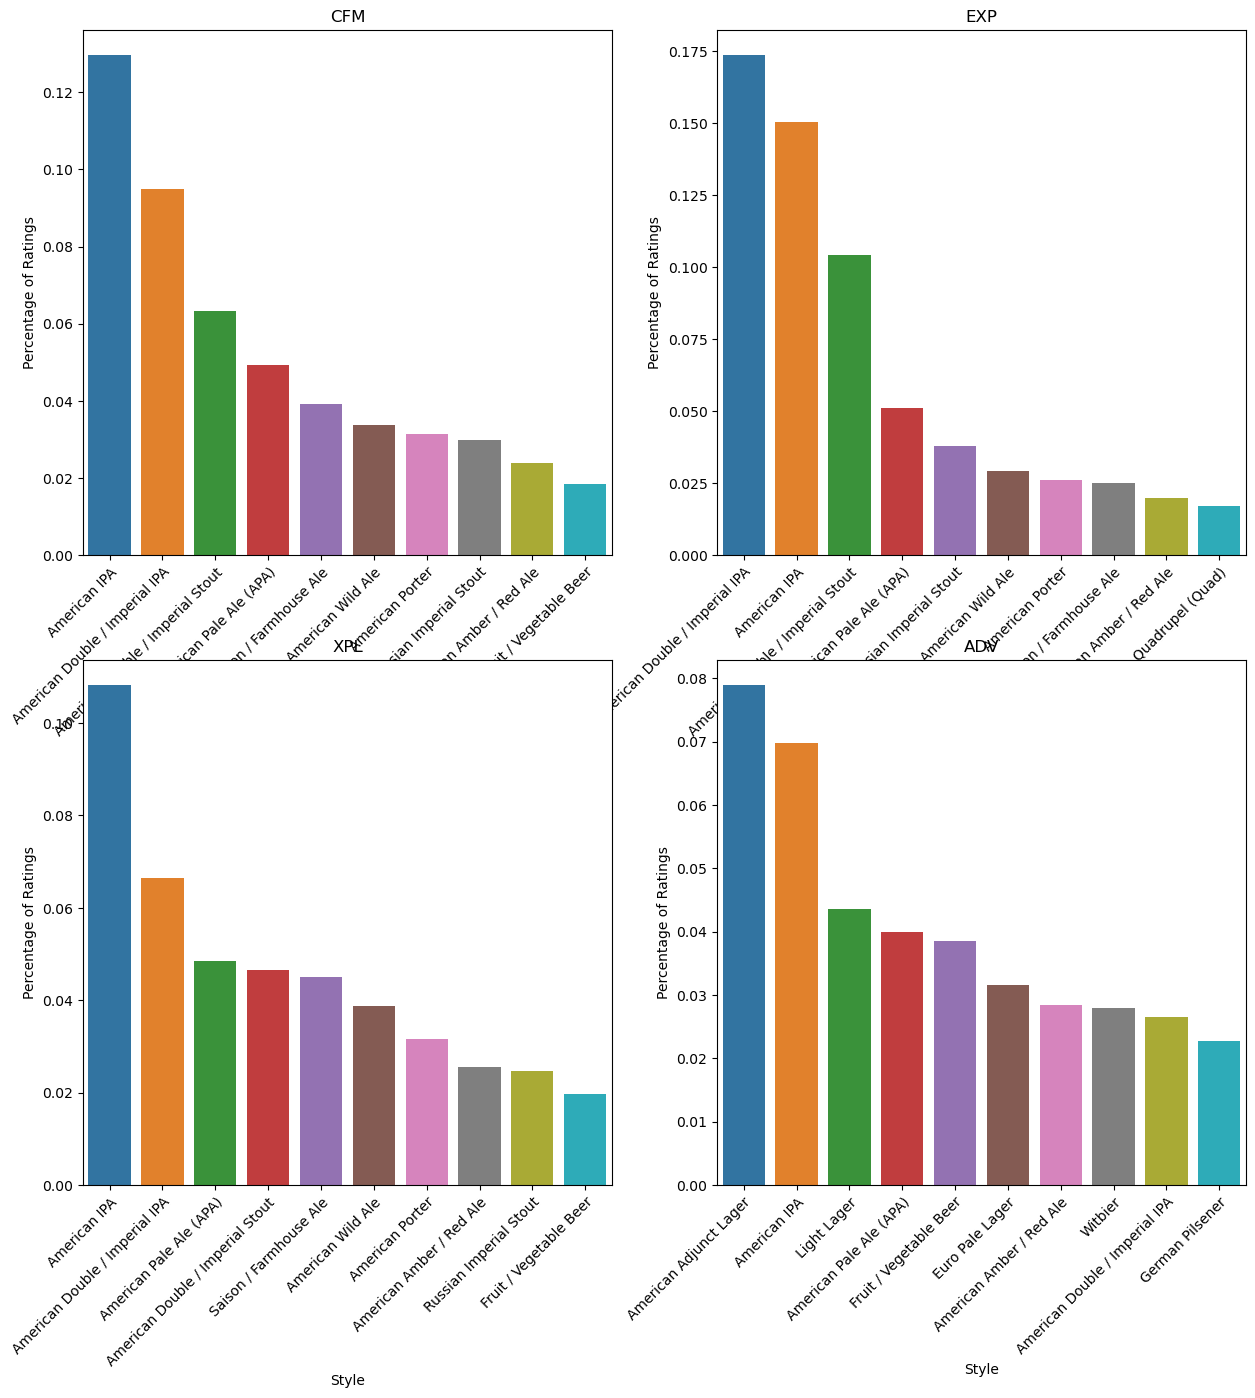

In [66]:
# same plot as above but with vertical bars and make the text diagonal under the bars
fig, axs = plt.subplots(2, 2, figsize=(15, 15))
sns.barplot(y=cfm_style_count.values, x=cfm_style_count.index, ax=axs[0, 0])
sns.barplot(y=exp_style_count.values, x=exp_style_count.index, ax=axs[0, 1])
sns.barplot(y=xpl_style_count.values, x=xpl_style_count.index, ax=axs[1, 0])
sns.barplot(y=adv_style_count.values, x=adv_style_count.index, ax=axs[1, 1])

axs[0, 0].set_title("CFM")
axs[0, 1].set_title("EXP")
axs[1, 0].set_title("XPL")
axs[1, 1].set_title("ADV")

axs[0, 0].set_ylabel("Percentage of Ratings")
axs[0, 1].set_ylabel("Percentage of Ratings")
axs[1, 0].set_ylabel("Percentage of Ratings")
axs[1, 1].set_ylabel("Percentage of Ratings")

axs[0, 0].set_xlabel("Style")
axs[0, 1].set_xlabel("Style")
axs[1, 0].set_xlabel("Style")
axs[1, 1].set_xlabel("Style")

plt.setp(axs[0, 0].get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
plt.setp(axs[0, 1].get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
plt.setp(axs[1, 0].get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
plt.setp(axs[1, 1].get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

plt.show()

In [80]:
# create interactive vertical bar plot of top 10 styles for each category using style_count
# you can click on a category to display it and the plot are superimposed on each other

import plotly.graph_objects as go

fig = go.Figure()


fig.add_trace(go.Bar(
    y=cfm_style_count.values,
    x=cfm_style_count.index,
    name="CFM",
    orientation='v',
    marker_color='#FF0000'
))
fig.add_trace(go.Bar(
    y=exp_style_count.values,
    x=exp_style_count.index,
    name="EXP",
    orientation='v',
    marker_color='#00FF00'
))
fig.add_trace(go.Bar(
    y=xpl_style_count.values,
    x=xpl_style_count.index,
    name="XPL",
    orientation='v',

    marker_color='#0000FF'
))
fig.add_trace(go.Bar(
    y=adv_style_count.values,
    x=adv_style_count.index,
    name="ADV",
    orientation='v',
    marker_color='#FFFF00'
))




# set the x-axis to be the style names
fig.update_layout(xaxis={'categoryorder':'array', 'categoryarray':cfm_style_count.index})

# set the y-axis to be the percentage of ratings
fig.update_layout(yaxis_title="Percentage of Ratings")

# set the title
fig.update_layout(title_text="Top 10 rated beer styles for each Category")

fig.update_layout(barmode='group')
fig.show()


In [83]:
# same plot as above but when you click on a category it will be sorted by that category

fig = go.Figure()

fig.add_trace(go.Bar(
    y=cfm_style_count.values,
    x=cfm_style_count.index,
    name="CFM",
    orientation='v',
    marker_color='#FF0000'
))
fig.add_trace(go.Bar(
    y=exp_style_count.values,
    x=exp_style_count.index,
    name="EXP",
    orientation='v',
    marker_color='#00FF00'
))
fig.add_trace(go.Bar(
    y=xpl_style_count.values,
    x=xpl_style_count.index,
    name="XPL",
    orientation='v',

    marker_color='#0000FF'
))
fig.add_trace(go.Bar(
    y=adv_style_count.values,
    x=adv_style_count.index,
    name="ADV",
    orientation='v',
    marker_color='#FFFF00'
))

# set the x-axis to be the style names
fig.update_layout(xaxis={'categoryorder':'array', 'categoryarray':cfm_style_count.index})

# set the y-axis to be the percentage of ratings
fig.update_layout(yaxis_title="Percentage of Ratings")

# set the title
fig.update_layout(title_text="Top 10 rated beer styles for each Category")

fig.update_layout(barmode='group')

# add a dropdown menu to select the category
fig.update_layout(
    updatemenus=[
        dict(
            active=0,
            buttons=list([
                dict(label="CFM",
                        method="update",
                        args=[{"visible": [True, False, False, False]},
                            {"title": "CFM",
                            "xaxis": {'categoryorder':'array', 'categoryarray':cfm_style_count.index}}]),
                dict(label="EXP",
                        method="update",
                        args=[{"visible": [False, True, False, False]},
                            {"title": "EXP",
                            "xaxis": {'categoryorder':'array', 'categoryarray':exp_style_count.index}}]),
                dict(label="XPL",
                        method="update",
                        args=[{"visible": [False, False, True, False]},
                            {"title": "XPL",
                            "xaxis": {'categoryorder':'array', 'categoryarray':xpl_style_count.index}}]),
                dict(label="ADV",
                        method="update",
                        args=[{"visible": [False, False, False, True]},
                            {"title": "ADV",
                            "xaxis": {'categoryorder':'array', 'categoryarray':adv_style_count.index}}])
            ]),
        )
    ])

fig.show()



In [89]:
cfm_ratings.head()

,date,bid,uid,rating,has_review,review,compound,style
0,2014-01-25 11:00:00,19827,jaydoc.265507,3.25,False,None,0,English Pale Ale
1,2012-12-02 11:00:00,19827,byofb.537281,3.50,False,None,0,English Pale Ale
2,2012-07-14 10:00:00,19827,othershoe2.233642,3.68,True,Pours a rich brownish red with some chill haze...,0,English Pale Ale
3,2012-01-02 11:00:00,19827,animal69.160100,3.50,False,None,0,English Pale Ale
4,2011-09-07 10:00:00,19827,treyliff.490010,3.62,True,Pours a dark brown with a decent creamy head. ...,0,English Pale Ale


## What style of beer are more liked by each category

In [96]:
# group by cfm_ratings by style and get average rating for each style
cfm_ratings_by_style = cfm_ratings.groupby('style').mean().sort_values(by='rating', ascending=False)
exp_ratings_by_style = exp_ratings.groupby('style').mean().sort_values(by='rating', ascending=False)
xpl_ratings_by_style = xpl_ratings.groupby('style').mean().sort_values(by='rating', ascending=False)
adv_ratings_by_style = adv_ratings.groupby('style').mean().sort_values(by='rating', ascending=False)

# normalize the avg ratings by dividing by the average rating for all their ratings
cfm_ratings_by_style['norm_rating'] = cfm_ratings_by_style['rating'] / cfm_ratings['rating'].mean()
exp_ratings_by_style['norm_rating'] = exp_ratings_by_style['rating'] / exp_ratings['rating'].mean()
xpl_ratings_by_style['norm_rating'] = xpl_ratings_by_style['rating'] / xpl_ratings['rating'].mean()
adv_ratings_by_style['norm_rating'] = adv_ratings_by_style['rating'] / adv_ratings['rating'].mean()

In [98]:
# get the top 10 styles for each category
cfm_ratings_by_style_top10 = cfm_ratings_by_style.head(10)
exp_ratings_by_style_top10 = exp_ratings_by_style.head(10)
xpl_ratings_by_style_top10 = xpl_ratings_by_style.head(10)
adv_ratings_by_style_top10 = adv_ratings_by_style.head(10)

In [104]:
cfm_ratings_by_style_top10

,bid,rating,has_review,compound,norm_rating
style,,,,,
Gueuze,41152.901423,4.279337,0.239643,0.0,1.090345
American Double / Imperial Stout,95337.416583,4.271372,0.217386,0.0,1.088315
Russian Imperial Stout,58034.193964,4.204332,0.275130,0.0,1.071234
Quadrupel (Quad),53387.653710,4.185874,0.302674,0.0,1.066531
Flanders Red Ale,62750.630511,4.172130,0.246463,0.0,1.063029
Eisbock,27121.087607,4.170085,0.413462,0.0,1.062508
American Wild Ale,124768.935140,4.162731,0.166163,0.0,1.060634
American Double / Imperial IPA,95953.064451,4.161204,0.230712,0.0,1.060245
English Barleywine,68887.504606,4.152700,0.310747,0.0,1.058079


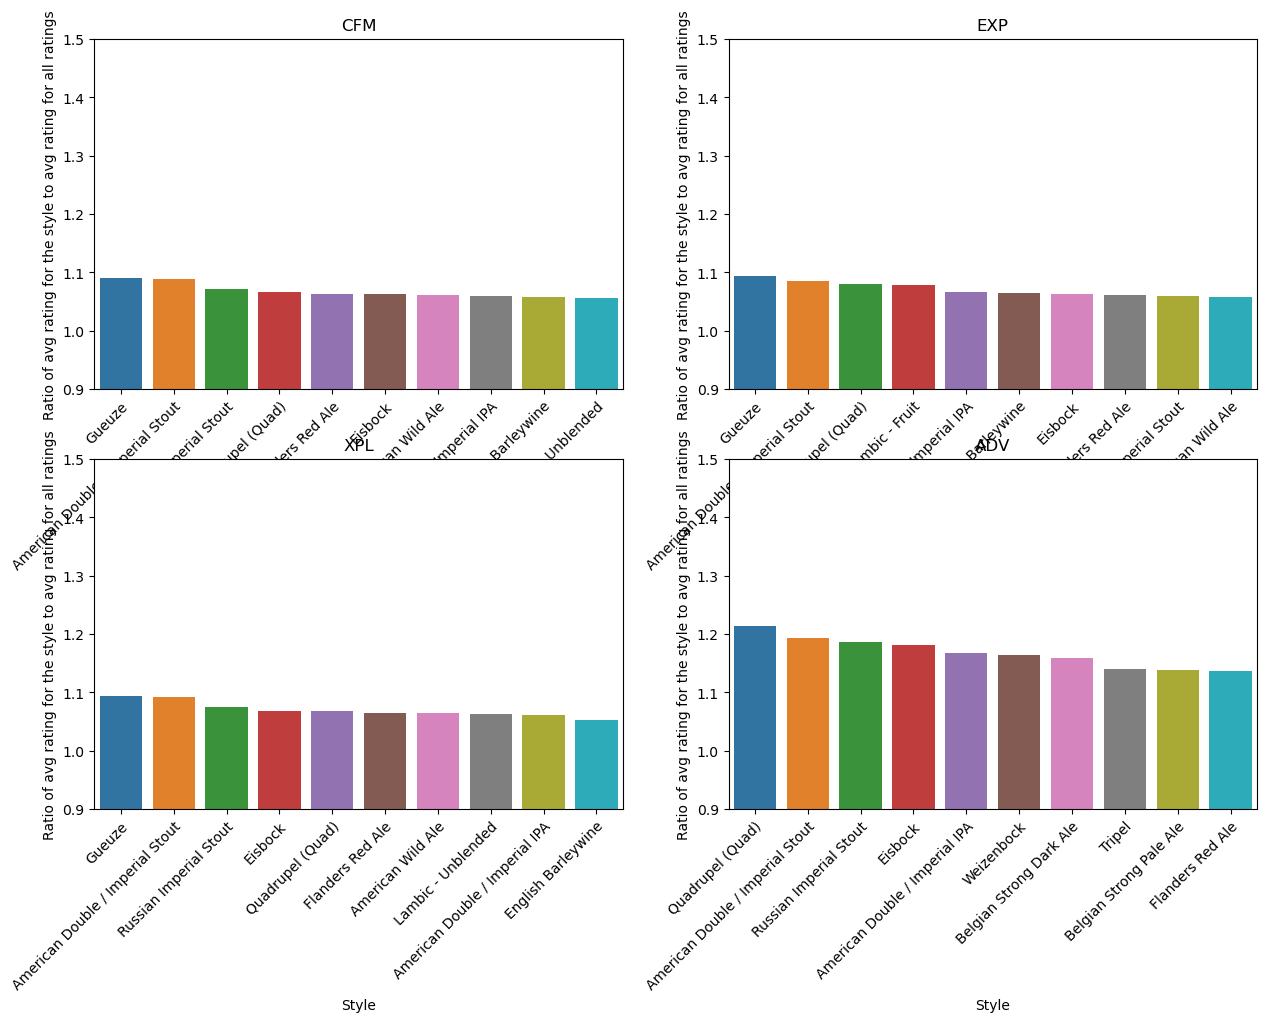

In [109]:
fig, axs = plt.subplots(2, 2, figsize=(15, 10))
sns.barplot(y=cfm_ratings_by_style_top10["norm_rating"].values, x=cfm_ratings_by_style_top10.index, ax=axs[0, 0])
sns.barplot(y=exp_ratings_by_style_top10["norm_rating"].values, x=exp_ratings_by_style_top10.index, ax=axs[0, 1])
sns.barplot(y=xpl_ratings_by_style_top10["norm_rating"].values, x=xpl_ratings_by_style_top10.index, ax=axs[1, 0])
sns.barplot(y=adv_ratings_by_style_top10["norm_rating"].values, x=adv_ratings_by_style_top10.index, ax=axs[1, 1])

axs[0, 0].set_title("CFM")
axs[0, 1].set_title("EXP")
axs[1, 0].set_title("XPL")
axs[1, 1].set_title("ADV")

axs[0, 0].set_ylabel("Ratio of avg rating for the style to avg rating for all ratings")
axs[0, 1].set_ylabel("Ratio of avg rating for the style to avg rating for all ratings")
axs[1, 0].set_ylabel("Ratio of avg rating for the style to avg rating for all ratings")
axs[1, 1].set_ylabel("Ratio of avg rating for the style to avg rating for all ratings")

axs[0, 0].set_xlabel("Style")
axs[0, 1].set_xlabel("Style")
axs[1, 0].set_xlabel("Style")
axs[1, 1].set_xlabel("Style")

plt.setp(axs[0, 0].get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
plt.setp(axs[0, 1].get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
plt.setp(axs[1, 0].get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
plt.setp(axs[1, 1].get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

# make the plot start at y = 0.9
axs[0, 0].set_ylim(0.9, 1.5)
axs[0, 1].set_ylim(0.9, 1.5)
axs[1, 0].set_ylim(0.9, 1.5)
axs[1, 1].set_ylim(0.9, 1.5)


plt.show()

In [111]:
# make the plot interactive
fig = go.Figure()

fig.add_trace(go.Bar(
    x=cfm_ratings_by_style_top10.index,
    y=cfm_ratings_by_style_top10["norm_rating"].values,
    name='CFM',
    marker_color='#FF0000'
))
fig.add_trace(go.Bar(
    x=exp_ratings_by_style_top10.index,
    y=exp_ratings_by_style_top10["norm_rating"].values,
    name='EXP',
    marker_color='#00FF00'
))
fig.add_trace(go.Bar(
    x=xpl_ratings_by_style_top10.index,
    y=xpl_ratings_by_style_top10["norm_rating"].values,
    name='XPL',
    marker_color='#0000FF'
))
fig.add_trace(go.Bar(
    x=adv_ratings_by_style_top10.index,
    y=adv_ratings_by_style_top10["norm_rating"].values,
    name='ADV',
    marker_color='#FFFF00'
))

# Change the bar mode
fig.update_layout(barmode='group', title="Top 10 Styles by Avg Rating for Each Difficulty")
fig.show()


TODO: 1) add in the analysis the baseline of all users regardless of category  
2) analysis of where the rating of each category go to (which country eg. belgium beers)  
3) where do the users of each category come from 